## DSCI 552 PS 1 - Used Car Dataset

In [1]:
## data preparation and analysis
import pandas as pd 
from pandas.plotting import scatter_matrix
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy as sp 
import statsmodels.api as sm
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

## modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv(r'data/used_car_dataset.csv')
print(df.shape)

(9997, 14)


In [3]:
df.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,type,paint_color,F1,F2,F3,F4
0,21978.0,2016.0,ford,like new,6 cylinders,gas,80813.0,automatic,SUV,black,138,2.472286,0.059031,b
1,4185.0,2008.0,ford,good,8 cylinders,gas,201800.0,automatic,SUV,white,415,2.285245,0.046328,c
2,7693.0,2002.0,ford,excellent,6 cylinders,gas,145000.0,automatic,pickup,white,535,1.861461,0.158554,b
3,15778.0,2016.0,ford,excellent,4 cylinders,gas,50103.0,automatic,sedan,white,3435,2.331671,0.213665,c
4,10520.0,2005.0,ford,good,8 cylinders,gas,207663.0,automatic,truck,white,1212,2.061082,0.388724,b


In [4]:
df.describe()

,price,year,odometer,F1,F2,F3
count,9997.000000,9997.000000,9.305000e+03,9997.000000,9997.000000,9997.000000
mean,14233.961989,2009.817345,1.139147e+05,1534.257377,2.224515,0.100247
std,12595.955311,8.847370,1.306907e+05,2138.048191,0.226997,0.100804
min,0.000000,1922.000000,0.000000e+00,4.000000,0.167352,-0.313948
25%,5594.000000,2007.000000,6.702100e+04,308.000000,2.131407,0.030308
50%,10333.000000,2012.000000,1.110000e+05,698.000000,2.255297,0.101295
75%,19389.000000,2015.000000,1.512140e+05,2013.000000,2.361656,0.167654
max,402498.000000,2021.000000,9.999999e+06,36773.000000,2.728576,0.526848


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         9997 non-null   float64
 1   year          9997 non-null   float64
 2   manufacturer  9997 non-null   object 
 3   condition     9997 non-null   object 
 4   cylinders     9997 non-null   object 
 5   fuel          9997 non-null   object 
 6   odometer      9305 non-null   float64
 7   transmission  9997 non-null   object 
 8   type          9997 non-null   object 
 9   paint_color   9997 non-null   object 
 10  F1            9997 non-null   int64  
 11  F2            9997 non-null   float64
 12  F3            9997 non-null   float64
 13  F4            9997 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory usage: 1.1+ MB


# EDA / cleaning / transforming step
Your CEO said: “The dataset describes conditions of various used cars and their current prices.
I would like to learn **what drives prices of used cars**. 

1. Look at the dataset and find the **main factors**
that affect the **value** of a car – and then explain it to me. 

2. Additionally, assess the **impact** of some special modifications (denoted by **F1, F2, F3 and F4** in your dataset) on the price. This would help us to understand, **if we should make the modifications before selling a car or not**. I would
like to see the report, describing your main findings, on my desk, on Thursday, February 11,
2021 at 10 A.M. “

Hint: You are asked to **find general trends** in the data. Report whatever you think is the most important. Your CEO
doesn’t want to see a list that is 20-times long. She would like to learn just about some general trends. To give you
an example, one general trend could be “The price decrease with the age of the car. Holding all other factors
constant, with each year, the price of a car decreases by \$570. However, these dynamics are not constant. Value of
younger cars decreases faster than the value of an old car. For example, the value of cars that are less than 5 years
old, decreases nearly $2,500 per year.” (This is just an example; your numbers might be different). Your second
task you have to check both, the **impact** and the **statistical significance** of the **F1-F4 attributes** for making the price predictions.



In [6]:
### NOTE:
## Due to skewed datasets, we should clean data by:
## fill missing vals (median imputation)
## scale the datasets (minmaxscaler)
## remove outliers
## and one-hot encoding for categorical vars (to prep for model)

In [7]:
## MISSING VALUES
# df.isnull().sum()  ## check for missing vals
# ## fill in missing values with mean imputation
# df['odometer'].fillna(df['odometer'].mean(), inplace=True)
# # df.isnull().sum()  ## check for missing vals

In [8]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

In [9]:
min_max_scaler = MinMaxScaler()
nums_scaled = pd.DataFrame(min_max_scaler.fit_transform(df[num_cols]))
nums_scaled.columns = num_cols

In [10]:
## Outlier removal: get indicies of outlier locations
outlier_locs = []
for col in num_cols:
    curr = df[col]
    mean, std = np.mean(curr), np.std(curr)
    cut_off = std * 3
    lower, upper = mean - cut_off, mean + cut_off
    # print(col, lower, upper)  
    for idx, val in curr.items():
        if val < lower or val > upper:
            outlier_locs.append(idx)

In [11]:
outliers = list(set(outlier_locs))
## df2 is just df without the outliers
df2 = df.drop(df.index[outliers])
nums_scaled2 = nums_scaled.drop(nums_scaled.index[outliers])
print(df.shape, df2.shape)

(9997, 14) (9603, 14)


In [12]:
# ## plot data
# df2.hist(bins=50, figsize=(16,8))
# plt.savefig('images/hist_1.png')

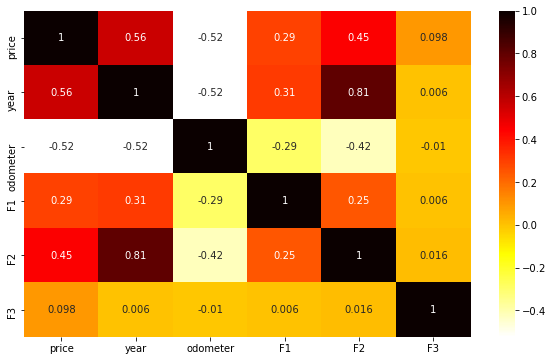

In [13]:
# ## View correlations btwn features
## focus on effect on PRICE
plt.figure(figsize=(10,6))
sns.heatmap(df2.corr(), annot=True, cmap="hot_r")
plt.savefig('images/heatmap_1.png')

In [14]:
# scatter_matrix(df2[num_cols], figsize=(12,10))
# plt.savefig('images/scatter_matrix_num_cols.png')

In [15]:
# ## boxplots for numerical vars
# fig, axes = plt.subplots(2, 3, sharex = False, figsize=(16,8))
# fig.suptitle('Boxplots')

# for i, var in enumerate(num_cols):
#     if i < 3:
#         row = 0
#     elif i >= 3: 
#         row = 1
#     col = i % 3
#     sns.boxplot(ax=axes[row,col], data=df2, x=var)
# plt.savefig('images/boxplots_1.png')

In [16]:
# ## Categorical vars and PRICE
# fig, axes = plt.subplots(2, 4, sharex = False, figsize=(16,8))
# fig.suptitle('Categorical Vars and Price')
# for i, var in enumerate(cat_cols):
#     if i < 4:
#         row = 0
#     elif i >= 4: 
#         row = 1
#     col = i % 4
#     axes[row][col] = sns.stripplot(x=var, y='price', data=df2, ax=axes[row][col])
# fig.tight_layout()
# plt.savefig('images/catplots_and_price_1.png')


In [17]:
df2.corr()

,price,year,odometer,F1,F2,F3
price,1.000000,0.563192,-0.522992,0.294267,0.448100,0.097532
year,0.563192,1.000000,-0.523170,0.311200,0.808506,0.006014
odometer,-0.522992,-0.523170,1.000000,-0.290476,-0.417951,-0.010065
F1,0.294267,0.311200,-0.290476,1.000000,0.249972,0.005959
F2,0.448100,0.808506,-0.417951,0.249972,1.000000,0.016433
F3,0.097532,0.006014,-0.010065,0.005959,0.016433,1.000000


In [18]:
## TODO: write about trends btwn price and various features (how they correlate as they go up or down) in the report 

In [19]:
df2.head()


,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,type,paint_color,F1,F2,F3,F4
0,21978.0,2016.0,ford,like new,6 cylinders,gas,80813.0,automatic,SUV,black,138,2.472286,0.059031,b
1,4185.0,2008.0,ford,good,8 cylinders,gas,201800.0,automatic,SUV,white,415,2.285245,0.046328,c
2,7693.0,2002.0,ford,excellent,6 cylinders,gas,145000.0,automatic,pickup,white,535,1.861461,0.158554,b
3,15778.0,2016.0,ford,excellent,4 cylinders,gas,50103.0,automatic,sedan,white,3435,2.331671,0.213665,c
4,10520.0,2005.0,ford,good,8 cylinders,gas,207663.0,automatic,truck,white,1212,2.061082,0.388724,b


<AxesSubplot:title={'center':'price vs year'}, xlabel='year', ylabel='price'>

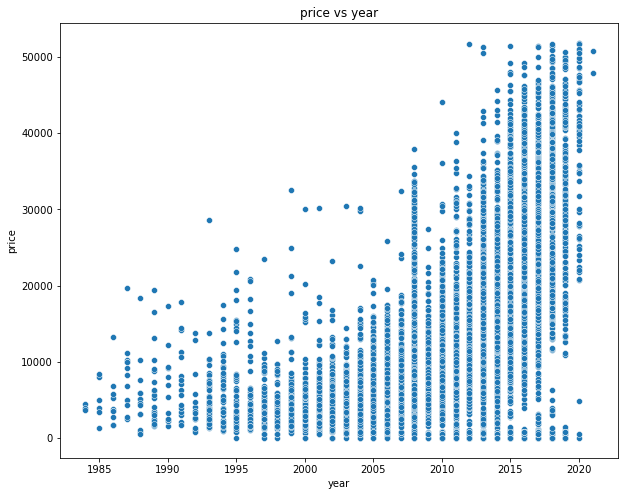

In [20]:
plt.figure(figsize=(10,8))
plt.title("price vs year")
sns.scatterplot(x='year', y='price', data=df2)
# plt.scatter(x=df2['year'], y=df2['price'])

<AxesSubplot:title={'center':'price vs odometer'}, xlabel='odometer', ylabel='price'>

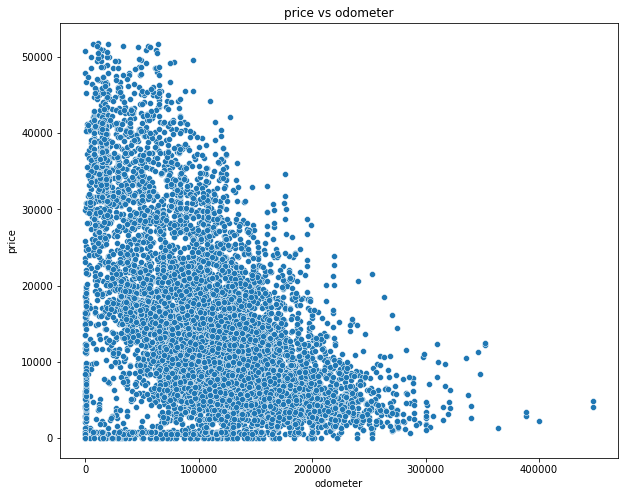

In [21]:
plt.figure(figsize=(10,8))
plt.title("price vs odometer")
sns.scatterplot(x='odometer', y='price', data=df2)
# plt.scatter(x=df2['year'], y=df2['price'])

In [22]:
### TODO: Verify if this approach is correct??? 
## Hypothesis Testing for stat sig of F1 - F4 attributes: fit OLS model and check p-values
## null: Fk has no effect on price VS alt: Fk has an effect on price

X = df2[['F1', 'F2', 'F3']].values
## Convert categorical var to dummy var
F4 = pd.get_dummies(df2['F4'], drop_first=True).values
X = np.concatenate((X, F4), axis=1)
X = sm.add_constant(X)
y = df2['price'].values
# ## add col of ones
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     622.4
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:27:54   Log-Likelihood:            -1.0165e+05
No. Observations:                9603   AIC:                         2.033e+05
Df Residuals:                    9597   BIC:                         2.034e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.652e+04   1318.497    -35.285      0.000   -4.91e+04   -4.39e+04
x1             1.3551      0.064     21.213      0.000       1.230       1.480
x2          2.568e+04    590.780     43.472      0.000    2.45e+04    2.68e+04
x3          9954.4984    981.146     10.146      0.000    8031.244    1.19e+04
x4           -17.3432    237.638     -0.073      0.942    -483.165     448.478
x5          -568.1441    241.477     -2.353      0.019   -1041.490     -94.798
==============================================================================
Omnibus:                      828.950   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1139.811
Skew:                           0.715   Prob(JB):                    3.11e-248
Kurtosis:                       3.896   Cond. No.                     3.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Prediction Modeling , Tuning, and Evaluation 
Your Technical Manager said: “I would like you to propose a **predictive model**, that can be used to determine price of a used car. The problem is that the state-law demands that this model be easily interpretable. It means that we are restricted to use simple methods like **Linear Regression, Ridge Regression, LASSO and Elastic Net**. Additionally, we need to know how **accurate** the model is. You must choose the best model and report its **root mean square error**. Describe everything in your report and I will study it carefully”.
Hint: In the most typical approach, you need to build three datasets: **a training set, a validation set and a test set**. You will use **validation set** (for tuning model hyperparameters) to determine the best model; the test set to estimate model accuracy. In your report you should describe how you trained the models, how you selected the best one and how you tested its performance at the end.

In [23]:
## TRANSFORM STEP (After outlier removal)
## Transforms the dataset to prep for model
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('minmaxscaler', MinMaxScaler())
])

full_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_cols),
    ("categorical", OneHotEncoder(), cat_cols)
])

arr_cleaned = full_pipeline.fit_transform(df2)
print(arr_cleaned.shape)## After outlier removal

(9603, 30)


In [24]:
## split in train/test/valid
X = arr_cleaned[:,1:]
y = arr_cleaned[:,0]  ## price variable
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
print(X_train.shape, X_test.shape)

(9603, 29) (9603,)
(7682, 29) (1921, 29)


In [25]:
# ## Linear Reg Model - TEST (use sklearn)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print('Coefficients: \n', lin_reg.coef_)
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'Coefficient of determination R^2: {r2_score(y_test, y_pred)}')

Coefficients: 
 [ 6.58002111e-01 -4.58493632e-01  5.08046091e-02  7.27723088e-04
  1.18462741e-01  1.02398655e+11  1.02398655e+11 -7.22713502e+11
 -7.22713502e+11 -7.22713502e+11 -7.22713502e+11  1.78341219e+12
  1.78341219e+12  1.78341219e+12 -1.23693373e+12  6.77948729e+11
  6.77948729e+11 -5.90374749e+12 -5.90374749e+12 -5.90374749e+12
 -5.90374749e+12 -1.08578893e+13 -1.08578893e+13 -1.08578893e+13
 -1.08578893e+13 -1.08578893e+13 -4.14242051e+12 -4.14242051e+12
 -4.14242051e+12]
Mean squared error: 0.019652955905571857
Coefficient of determination R^2: 0.56641872428702


In [26]:
# ## Linear Reg Model - TEST (use sm)
# X0_train = sm.add_constant(X_train)
# model = sm.OLS(y_train, X0_train).fit()
# model.summary()

## Spot check / Compare models
#### try diff models compare results using kfold cv

In [29]:
# create a dict of standard models to evaluate
def define_models(models=dict()):
    models['linear_reg'] = LinearRegression()
    alpha = [round(x, 2) for x in np.linspace(0,1,11)]
    for a in alpha:
        models['lasso_reg_'+str(a)] = Lasso(alpha=a)
        models['ridge_reg_'+str(a)] = Ridge(alpha=a)
        models['en_reg_'+str(a)] = ElasticNet(alpha=a)
    return models
 
# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
	# evaluate model
	scores = cross_val_score(estimator=model, X=X, y=y, scoring=metric, cv=folds, n_jobs=1)
	return scores

## see more metrics on sklearn docs
## https://scikit-learn.org/stable/modules/model_evaluation.html

## e.g. using RMSE (LOWER (i.e. more negative vals) = better fit)

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=5, metric='neg_root_mean_squared_error'):   
    results = dict()
    print(f"Using {metric} metric for scores below:\n")
    for name, model in models.items():
        # scores = robust_evaluate_model(X, y, model, folds, metric)
        scores = evaluate_model(X, y, model, folds, metric)
        if scores is not None:
            results[name] = scores
            mean_score, std_score = np.mean(scores), np.std(scores)
            print(f'{name}: Mean:{mean_score:.3f}, St.Dev:{std_score:.3f}')
        else:
            print(f'{name}: error')
    return results

In [30]:
models = define_models() 
results = evaluate_models(X, y, models)

Using neg_root_mean_squared_error metric for scores below:

linear_reg: Mean:-0.135, St.Dev:0.003
lasso_reg_0.0: Mean:-0.135, St.Dev:0.002
ridge_reg_0.0: Mean:-0.136, St.Dev:0.002
en_reg_0.0: Mean:-0.135, St.Dev:0.002
lasso_reg_0.1: Mean:-0.212, St.Dev:0.004
ridge_reg_0.1: Mean:-0.135, St.Dev:0.002
en_reg_0.1: Mean:-0.212, St.Dev:0.004
lasso_reg_0.2: Mean:-0.212, St.Dev:0.004
ridge_reg_0.2: Mean:-0.135, St.Dev:0.002
en_reg_0.2: Mean:-0.212, St.Dev:0.004
lasso_reg_0.3: Mean:-0.212, St.Dev:0.004
ridge_reg_0.3: Mean:-0.135, St.Dev:0.002
en_reg_0.3: Mean:-0.212, St.Dev:0.004
lasso_reg_0.4: Mean:-0.212, St.Dev:0.004
ridge_reg_0.4: Mean:-0.135, St.Dev:0.002
en_reg_0.4: Mean:-0.212, St.Dev:0.004
lasso_reg_0.5: Mean:-0.212, St.Dev:0.004
ridge_reg_0.5: Mean:-0.135, St.Dev:0.002
en_reg_0.5: Mean:-0.212, St.Dev:0.004
lasso_reg_0.6: Mean:-0.212, St.Dev:0.004
ridge_reg_0.6: Mean:-0.135, St.Dev:0.002
en_reg_0.6: Mean:-0.212, St.Dev:0.004
lasso_reg_0.7: Mean:-0.212, St.Dev:0.004
ridge_reg_0.7: Mean:-

In [35]:
mean_results = {name: np.round(np.mean(arr), 4) for name, arr in results.items()}
len(mean_results)

34

In [38]:
## sort results with 'best' models first (having lowest error scores)
sorted(mean_results.items(), key=lambda x: x[1])

[('lasso_reg_0.1', -0.2124),
 ('en_reg_0.1', -0.2124),
 ('lasso_reg_0.2', -0.2124),
 ('en_reg_0.2', -0.2124),
 ('lasso_reg_0.3', -0.2124),
 ('en_reg_0.3', -0.2124),
 ('lasso_reg_0.4', -0.2124),
 ('en_reg_0.4', -0.2124),
 ('lasso_reg_0.5', -0.2124),
 ('en_reg_0.5', -0.2124),
 ('lasso_reg_0.6', -0.2124),
 ('en_reg_0.6', -0.2124),
 ('lasso_reg_0.7', -0.2124),
 ('en_reg_0.7', -0.2124),
 ('lasso_reg_0.8', -0.2124),
 ('en_reg_0.8', -0.2124),
 ('lasso_reg_0.9', -0.2124),
 ('en_reg_0.9', -0.2124),
 ('lasso_reg_1.0', -0.2124),
 ('en_reg_1.0', -0.2124),
 ('ridge_reg_0.0', -0.1361),
 ('linear_reg', -0.1355),
 ('lasso_reg_0.0', -0.1346),
 ('en_reg_0.0', -0.1346),
 ('ridge_reg_0.1', -0.1346),
 ('ridge_reg_0.2', -0.1346),
 ('ridge_reg_0.3', -0.1346),
 ('ridge_reg_0.4', -0.1346),
 ('ridge_reg_0.5', -0.1346),
 ('ridge_reg_0.6', -0.1346),
 ('ridge_reg_0.7', -0.1346),
 ('ridge_reg_0.8', -0.1346),
 ('ridge_reg_0.9', -0.1346),
 ('ridge_reg_1.0', -0.1346)]

Looks like Lasso and EN at diff alpha values do equally well, better than ridge or plain lin reg.

In [48]:
# TODO: plot and evaluate results. also change the code above taken from MLM

# print and plot the top n results
def summarize_results(results, maximize=False, top_n=10):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k, np.mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = np.mean(results[name]), np.std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	plt.boxplot(scores, labels=names)
	_, labels = plt.xticks()
	plt.setp(labels, rotation=90)
	# pyplot.savefig('spotcheck.png')


Rank=1, Name=lasso_reg_0.1, Score=-0.212 (+/- 0.004)
Rank=2, Name=en_reg_0.1, Score=-0.212 (+/- 0.004)
Rank=3, Name=lasso_reg_0.2, Score=-0.212 (+/- 0.004)
Rank=4, Name=en_reg_0.2, Score=-0.212 (+/- 0.004)
Rank=5, Name=lasso_reg_0.3, Score=-0.212 (+/- 0.004)
Rank=6, Name=en_reg_0.3, Score=-0.212 (+/- 0.004)
Rank=7, Name=lasso_reg_0.4, Score=-0.212 (+/- 0.004)
Rank=8, Name=en_reg_0.4, Score=-0.212 (+/- 0.004)
Rank=9, Name=lasso_reg_0.5, Score=-0.212 (+/- 0.004)
Rank=10, Name=en_reg_0.5, Score=-0.212 (+/- 0.004)


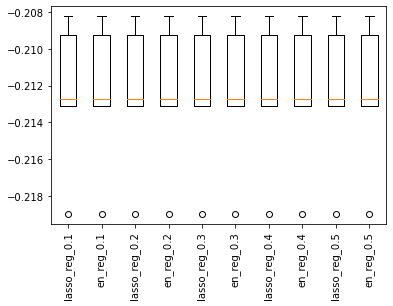

In [49]:
summarize_results(results)

The Senior Developer took you aside and said: “My task is to deploy your model to
production. But I cannot deploy a paper-report. I need your code. However, remember that I am
not a Data Scientist list you. I have a different expertise. I will read your code, but you should
make sure that I can follow and understand it – and that I know how to use it.”


Hint: In the ideal case, people should be able to take your code, run it and recreate all your results. In a less ideal case, it should be a **demonstration of typical run**. The code should **demonstrate your approach end-to-end**. People should just specify the path to the dataset, run it and see final results. Another name for this is a technical demo. At your future work, you might be quite often asked to demo your results. People will expect you to present an end-to- end example where you read the raw data, train your model and evaluate the results of the predictions.